In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

# Sampling a 16-d funnel

In [2]:
D = 16 # number of dims
a = 1.
b = 0.5
lower = np.full(D, -30.) # lower bound of the prior for x_1, ...
upper = np.full(D, 30.) # upper bound of the prior for x_1, ...
lower[0] = -4 # lower bound of the prior for x_0
upper[0] = 4 # upper bound of the prior for x_0
bound = np.array((lower, upper)).T
diff = bound[:, 1] - bound[:, 0]
const = np.sum(np.log(diff)) # normalization of the flat prior

def log_like(x):
    _a = jax.scipy.stats.norm.logpdf(x[0], loc=0, scale=a)
    _b = jnp.sum(jax.scipy.stats.norm.logpdf(x[1:], loc=0, scale=jnp.exp(b * x[..., 0])))
    return _a + _b

def log_flat_prior(x):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc=lower, scale=upper-lower))

jax_prior_init = jax.random.uniform(key, shape=(20 * D, D), minval=lower, maxval=upper)
print(jnp.amax(jax_prior_init[:, 5]))
print(jnp.amin(jax_prior_init[:, 5]))

x_prime = np.random.normal(0, 1, size=(1000, D))
x_prime[:, 0] = x_prime[:, 0] * a
x_prime[:, 1:] = x_prime[:, 1:] * np.exp(b * x_prime[:, 0]).reshape((1000, 1))

29.991547
-29.992462


Below I have defined the key parameters that I think you will need to worry about. If you look at the actual code you'll see a lot more parameters. Some of these are from older versions of the algorithm, and some of these are only relevant for the NFO optimization algorithm. We'll tidy this up at some point, but this should be enough to get you going.

In [24]:
'''
General parameters
------------------
In addition to the log-likelihood and prior functions defined above that you'll pass, we have:

1. log_like_args: Any additional arguments to be passed to the log-likelihood function as a tuple object.
2. log_prior_args: As above but for the prior. Not necessary here, but I've included arguments for illustration.
3. inference_mode: Either 'optimization' or 'sampling'. You'll want 'sampling'.
4. vmap: If True we evaluate the log-likelihood and prior functions using a vectorizing map (i.e. jax.vmap). 
   If False we parallelise the computation over available cores. The parallelisation has been tested on NERSC, 
   but I've pretty much exclusively been using vmap (you may want to parallelise if you have some very expensive 
   likelihoods).
5. parallel_backend: If using parallel evaluations, choose the parallel backend. Can be set to Pool, Client or
   MapReduce. Will use multiprocess, dask or sharedmem respectively. If left as None, will use multiprocess.
6. bounds: Any hard parameter bounds to pass to SINF/SNF. Passed as array([lower_bounds, upper_bounds]). None
   if no hard bounds.
7. k_trunc: Clipping parameter for importance weights. IW clipped at <IW>*N^k_trunc. Note, not currently used
   with SMC-type sampling.
8. random_seed: Random seed for inference.
'''
log_like_args = ()
log_prior_args = () 
inference_mode = 'sampling'
vmap = True
parallel_backend = None
bounds = np.array([lower, upper])
k_trunc = 0.5
random_seed = seed

'''
SINF/SNF parameters
---------------
Key SINF/SNF parameters. See GIS.py, SINF.py and optimize.py for code.

1. alpha_w: Regularisation parameters for weighted q SINF fits. Passed as a tuple of two values between 0 and 1. 
   Closer to 1 will give more regularisation. If set to None, SINF uses cross-validation to choose a value.
2. NBfirstlayer: Whether to use a Naive Bayes first layer in SINF.
3. verbose: Whether you want verbose output from SINF.
4. interp_nbin: Number of spline knots for rational quadratic splines in SINF. 
5. trainable_qw: Whether to run SNF after SINF. This was relevant when SINF and SNF were contained in the same
   method. There are separate methods now, and I'm using this so I can more easily change things. You should
   probably leave this as False for now. It won't break anything if you set it as True. Just means you'll run 
   SNF one more time than you think.
6. sgd_steps: Number of stochastic gradient descent steps to take for SNF training.
7. gamma: Parameter in loss function 1 (log E(q^(-gamma)*(p - Zq)^2)). 
8. knots_trainable: Only relevant if trainable_qw is True, in which case this overwrites interp_nbin.
9. optimize_directions: Whether we optimize directions in SNF.
10. logp_cut: logp threshold to be applied during SNF training. Currently I don't impose a cut.
11. edge_bins: Number of spline knots at the boundary.
12. Whiten: Whether to include a whitening layer for SINF.
13. iteration: Maximum number of SINF layers.
14. NERCOME: Whether to use the NERCOME algorithm for SINF.
'''
#sinf parameters
alpha_w = (0.9, 0.9)
NBfirstlayer = True
verbose = False
interp_nbin = 5
iteration = 5
trainable_qw = False # Just leave this for now.
sgd_steps = 10
gamma = 0
knots_trainable = 5
optimize_directions = False
logp_cut = None
edge_bins = 0
Whiten = True
Whiten_with_weights = False
iteration = 5
NERCOME = True
t_ess = 0.5

'''
SMC parameters
--------------
Parameters used for SMC and MH exploration strategies.

1. nfmc_frac_validate: Fraction of samples used in validation for SINF/SNF.
2. min_delta_beta_init: Minimum relative change in beta at start.
3. min_delta_beta_final: Minimum relative change in beta at end. delta_beta decays to this between start and end.
4. snf_loss: Specify the SNF loss function. (0) E(q^(-gamma)*(p - Zq)^2), (1) log E(q^(-gamma)*(p - Zq)^2),
   (2) sum((logp-logq-logZ)^2), (3) -E(logq), (4) log(E((q/q_uw)(p/q - Z)^2)).
5. nfmc_snf_only: Whether to only use trainable SNF updates to q after the first q fit.
6. fixed_beta_schedule: Can specify a fixed beta schedule as a list of beta values.
7. vanilla_smc: Whether to use the SMC+MH exploration strategy. This is currently the focus for sampling.
   Old option was to intialise using NFO optimization.
8. reg: SNF regularisation parameter.
9. reg1: SNF regularisation parameter.
10. mh_mode: Specify 'IMH' for independent MH exploration, 'CMH' for latent space MH, 'both' for using both.
    CMH is still being tested so stick with 'IMH' for now.
11. imh_target_acc_rate: Target acceptance fraction for original samples in IMH.
12. max_imh_steps: Maximum number of IMH iterations at a given temperature level.
13. cmh_target_acc_rate: Target acceptance rate for CMH exploration.
14. max_cmh_steps: Maximum number of steps in a CMH chain.
15. cmh_p_acc_rate: Parameter used for tuning number of CMH steps. Between 0 and 1. Closer to 1 results in more
    steps.
16. sinf_resampled: Whether to fit SINF using re-sampled samples and uniform weight.
'''
nfmc_frac_validate = 0.1
min_delta_beta_init = 0.01
min_delta_beta_final = 0.01
snf_loss = 2
nfmc_snf_only = False
fixed_beta_schedule = None
vanilla_smc = True
reg = 0.9
reg1 = 0.9
latent_mcmc = 'CMH'
imh_target_acc_rate = 0.5
max_imh_steps = 25
cmh_target_acc_rate = 0.234
max_cmh_steps = 25
cmh_p_acc_rate = 0.85
sinf_resampled = True
fixed_beta_updates = None
nf_iter = 100

Now we can run our 10d Gaussian example.

In [25]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args, 
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=NERCOME,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter)

Inference mode is sampling. Maximum beta is set to 1.
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.0005950927734375
Time taken for trainable qw = 0.13695731999996497
Running latent space MH sampling for 25 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.00877137016505003
Time taken for trainable qw = 0.19965126499999997
Running latent space MH sampling for 6 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.0462041349348965
Time taken for trainable qw = 0.20251490800001193
Running latent space MH sampling for 11 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.12180878449857299
Time taken for trainable qw = 0.18769964900002378
Running latent space MH sampling for 13 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.2135173399429786
Time taken for trainable qw = 0.19690920800002232
Running latent space 

The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [26]:
# Check the dictionary keys.
trace.keys()

dict_keys(['mcmc_samples', 'final_qw_samples', 'final_qw_weights', 'log_evidence', 'q_samples', 'importance_weights', 'logp', 'logq', 'train_logp', 'train_logq', 'logZ', 'q_models', 'q_ess', 'train_ess', 'total_ess', 'N', 'min_var_bws', 'min_pq_bws', '_t_sampling'])

In [27]:
# To inspect the sampling output, we can pull out the q_models.
q_models = trace['q_models'][0]
q_models.keys()
#print(len(q_models.keys()))

dict_keys(['q1_w', 'q2_w', 'q3_w', 'q4_w', 'q5_w', 'q6_w', 'q7_w', 'q8_w', 'q9_w', 'q10_w'])

In [28]:

# There were 10 temperature levels. q10_w corresponds to the q fit at beta=1 i.e. the target.
qi = q_models['q10_w']
q_samples, logq = qi.sample(2000, device='cpu')
q_samples, logq = q_samples.numpy(), logq.numpy()
iw = jax.vmap(lambda x: log_like(x))(q_samples)
logp = jax.vmap(lambda x: log_like(x))(q_samples)
logw = logp - logq
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

#q_samples = trace['final_qw_samples'][0]
#iw = trace['final_qw_weights'][0]

In [29]:
def plot_triangles(samples, weights, truth_samples, Ngd=1000, beta_idx=None,
                   out_name=None, d=16):

    names = ["x%s"%i for i in range(d)]
    labels =  ["x_%s"%i for i in range(d)]

    truth = MCSamples(samples=truth_samples, names=names,
                      labels=labels, label='Ground Truth')
    samples_w = MCSamples(samples=samples, weights=weights,
                          names=names, labels=labels, 
                          label='posterior samples')

    # Triangle plot
    plt.figure()
    g = plots.get_subplot_plotter()
    g.triangle_plot([truth, samples_w], filled=True)
    plt.show()
    if out_name is not None:
        g.export(out_name)

# Whiten=True, Whiten_with_weights=False, NERCOME=True

Don't have any no parameters in SNF errors. Final result has similar issue to vanilla SMC for funnel. Can be improved with repeated beta=1 fits.

Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

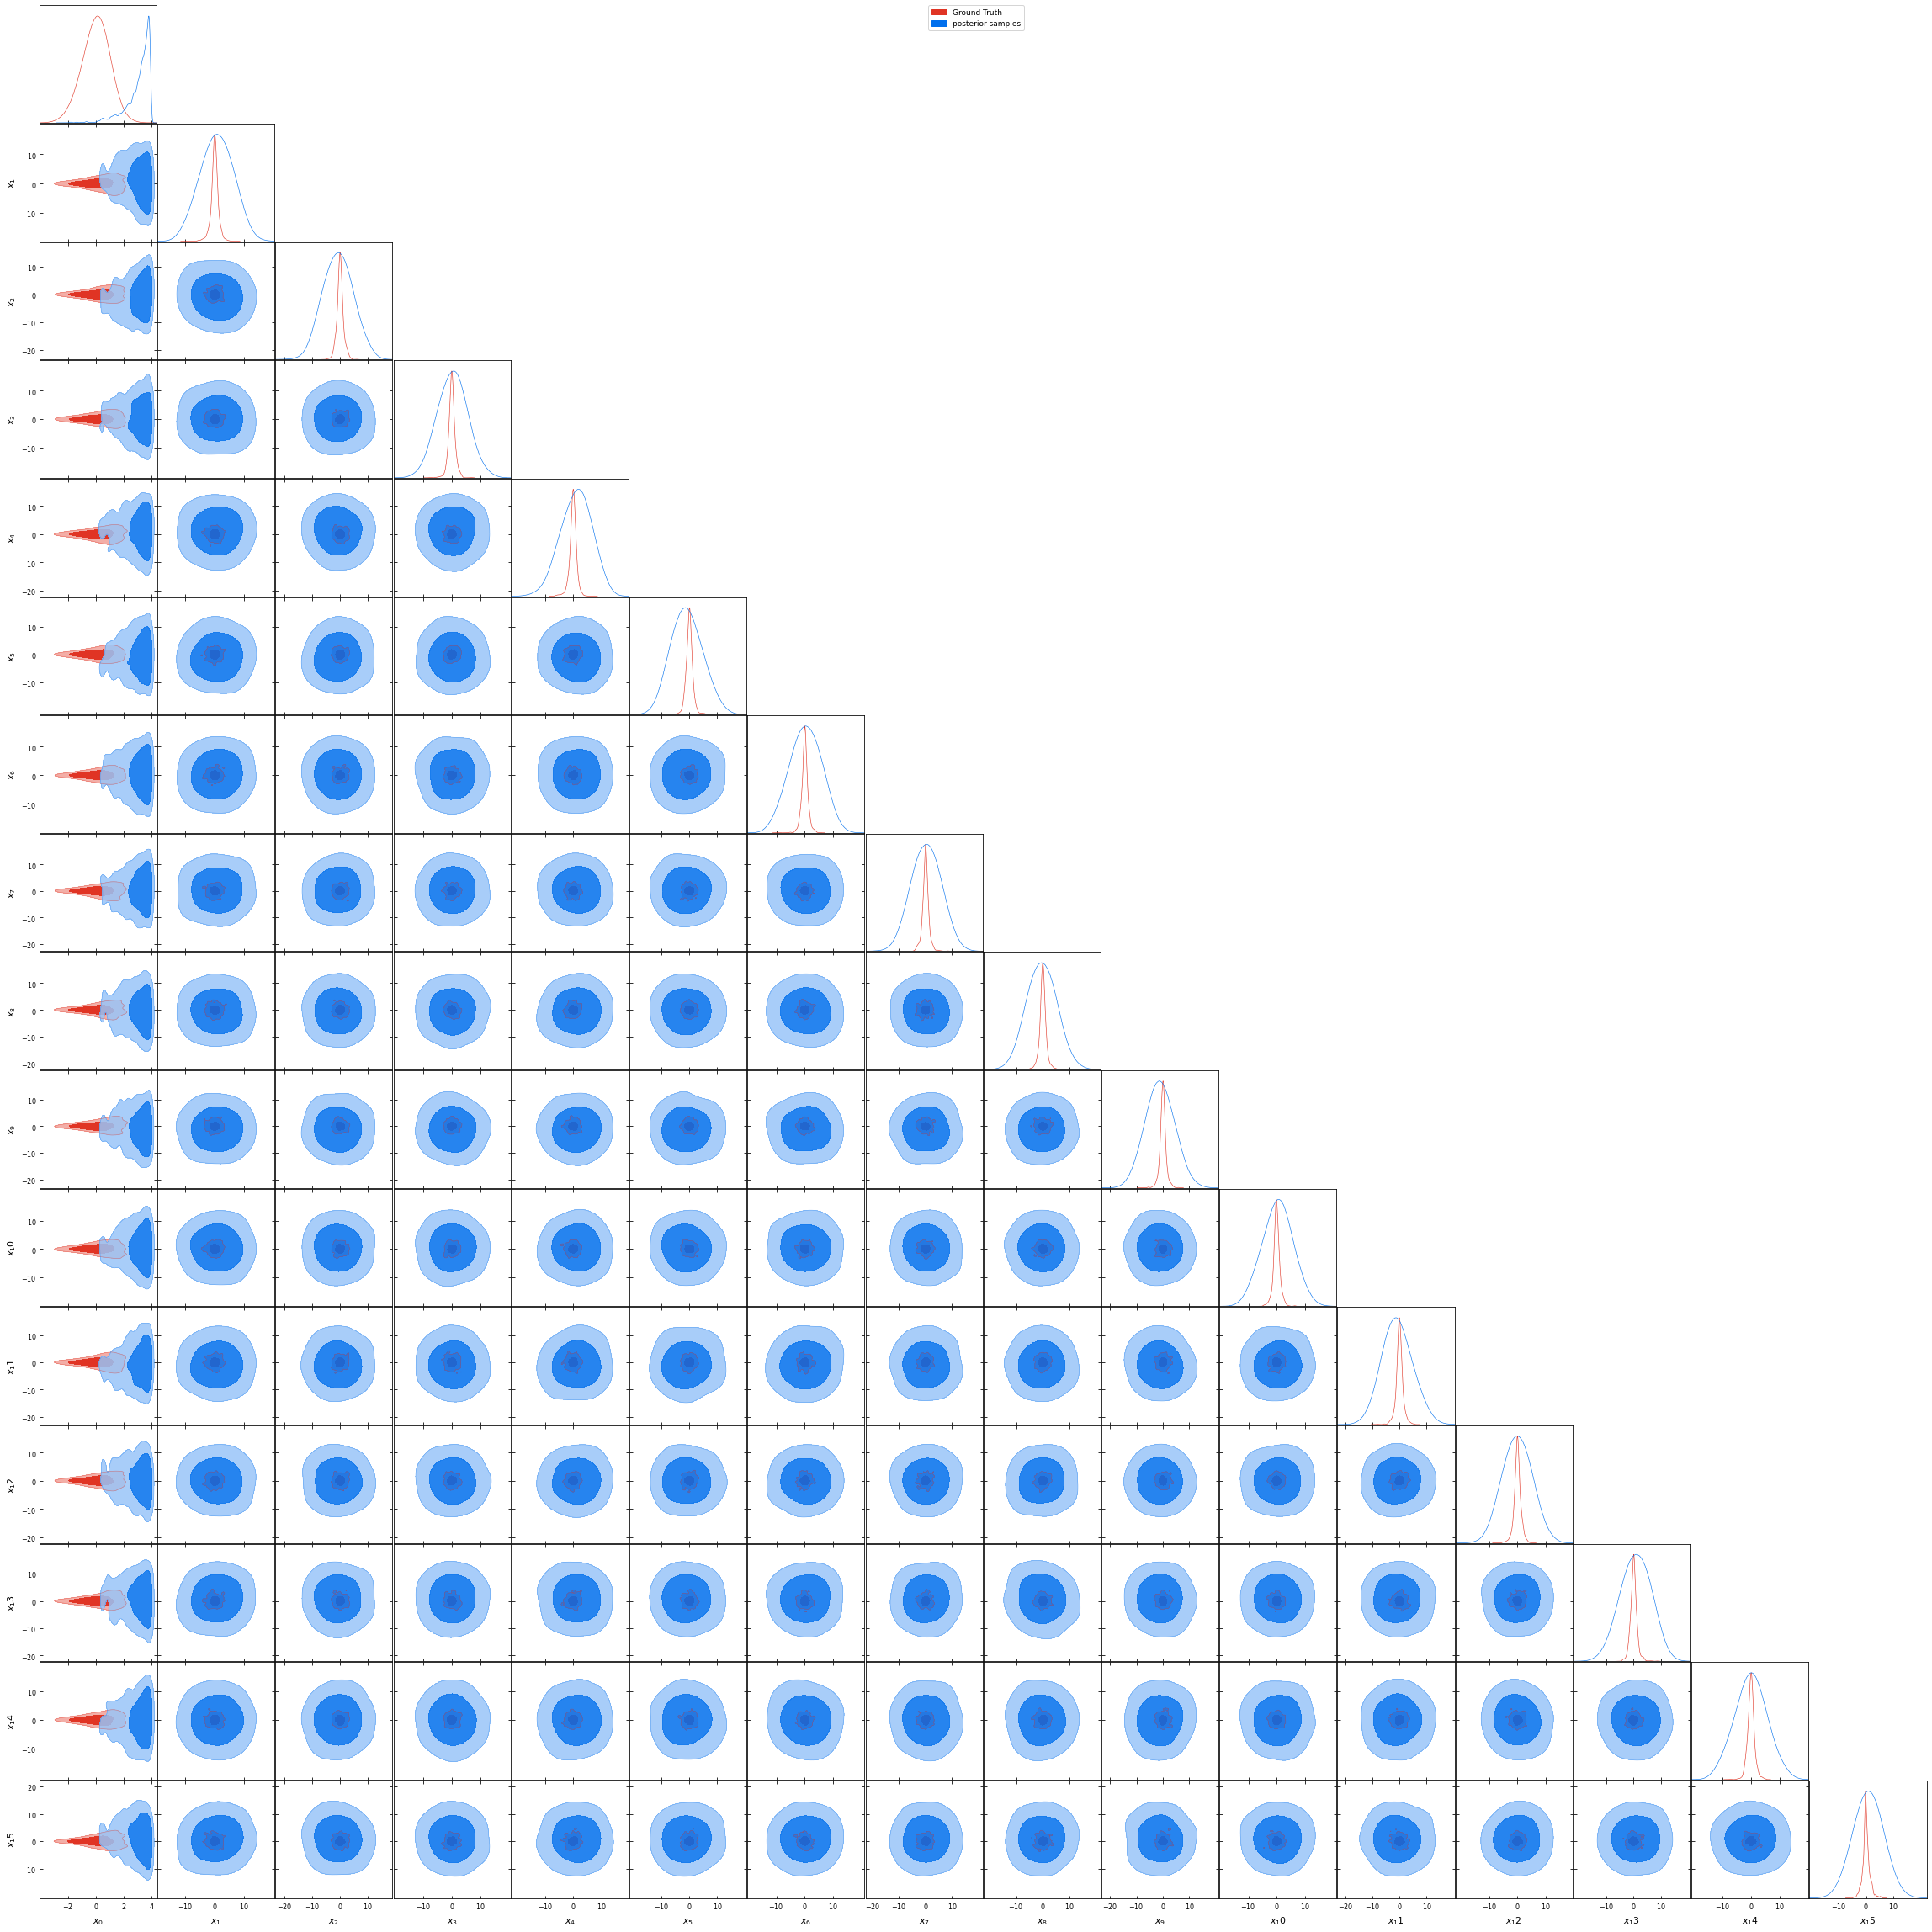

In [31]:
# First plot the samples without weights.
plot_triangles(q_samples, np.ones(len(q_samples)), truth_samples=x_prime, out_name='funnel_noweight_cmh.png')

# Whiten = True, Whiten_with_weghts = True, NERCOME = True

Hangs at beta=0.052157194934807194, after getting a no parameters in SNF error at beta=0.00889340415596962. Cannot run ...

In [32]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args, 
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=True,
                             Whiten_with_weights=True,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=True,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter)

Inference mode is sampling. Maximum beta is set to 1.
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.0005950927734375
Time taken for trainable qw = 0.08537766799997826
Running latent space MH sampling for 25 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.00889340415596962
There are no parameters in SNF!
Time taken for trainable qw = 0.003866915000003246
Running latent space MH sampling for 7 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.052157194934807194
Time taken for trainable qw = 0.19071650199998658
Running latent space MH sampling for 3 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.13490247034529146


KeyboardInterrupt: 

# Whiten = True, Whiten_with_weights = False, NERCOME = False
Runs, with similar issue to when NERCOME=True, albeit with less overlap with the funnel. This is actually more similar to the vanilla SMC result.

In [35]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args, 
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=True,
                             Whiten_with_weights=False,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=False,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter)

Inference mode is sampling. Maximum beta is set to 1.
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.0005950927734375
Time taken for trainable qw = 0.20016878100000213
Running latent space MH sampling for 25 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.01047984603792429
Time taken for trainable qw = 0.14606475200002933
Running latent space MH sampling for 6 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.056137779258733644
Time taken for trainable qw = 0.21094470200000615
Running latent space MH sampling for 10 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.13918853331872427
Time taken for trainable qw = 0.19229919600002177
Running latent space MH sampling for 9 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.24458605779871834
Time taken for trainable qw = 0.19915048600000773
Running latent spac

In [41]:
q_models = trace['q_models'][0]
print(list(q_models.keys())[-1])

qi = q_models[list(q_models.keys())[-1]]
q_samples, logq = qi.sample(2000, device='cpu')
q_samples, logq = q_samples.numpy(), logq.numpy()
iw = jax.vmap(lambda x: log_like(x))(q_samples)
logp = jax.vmap(lambda x: log_like(x))(q_samples)
logw = logp - logq
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

q9_w


Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

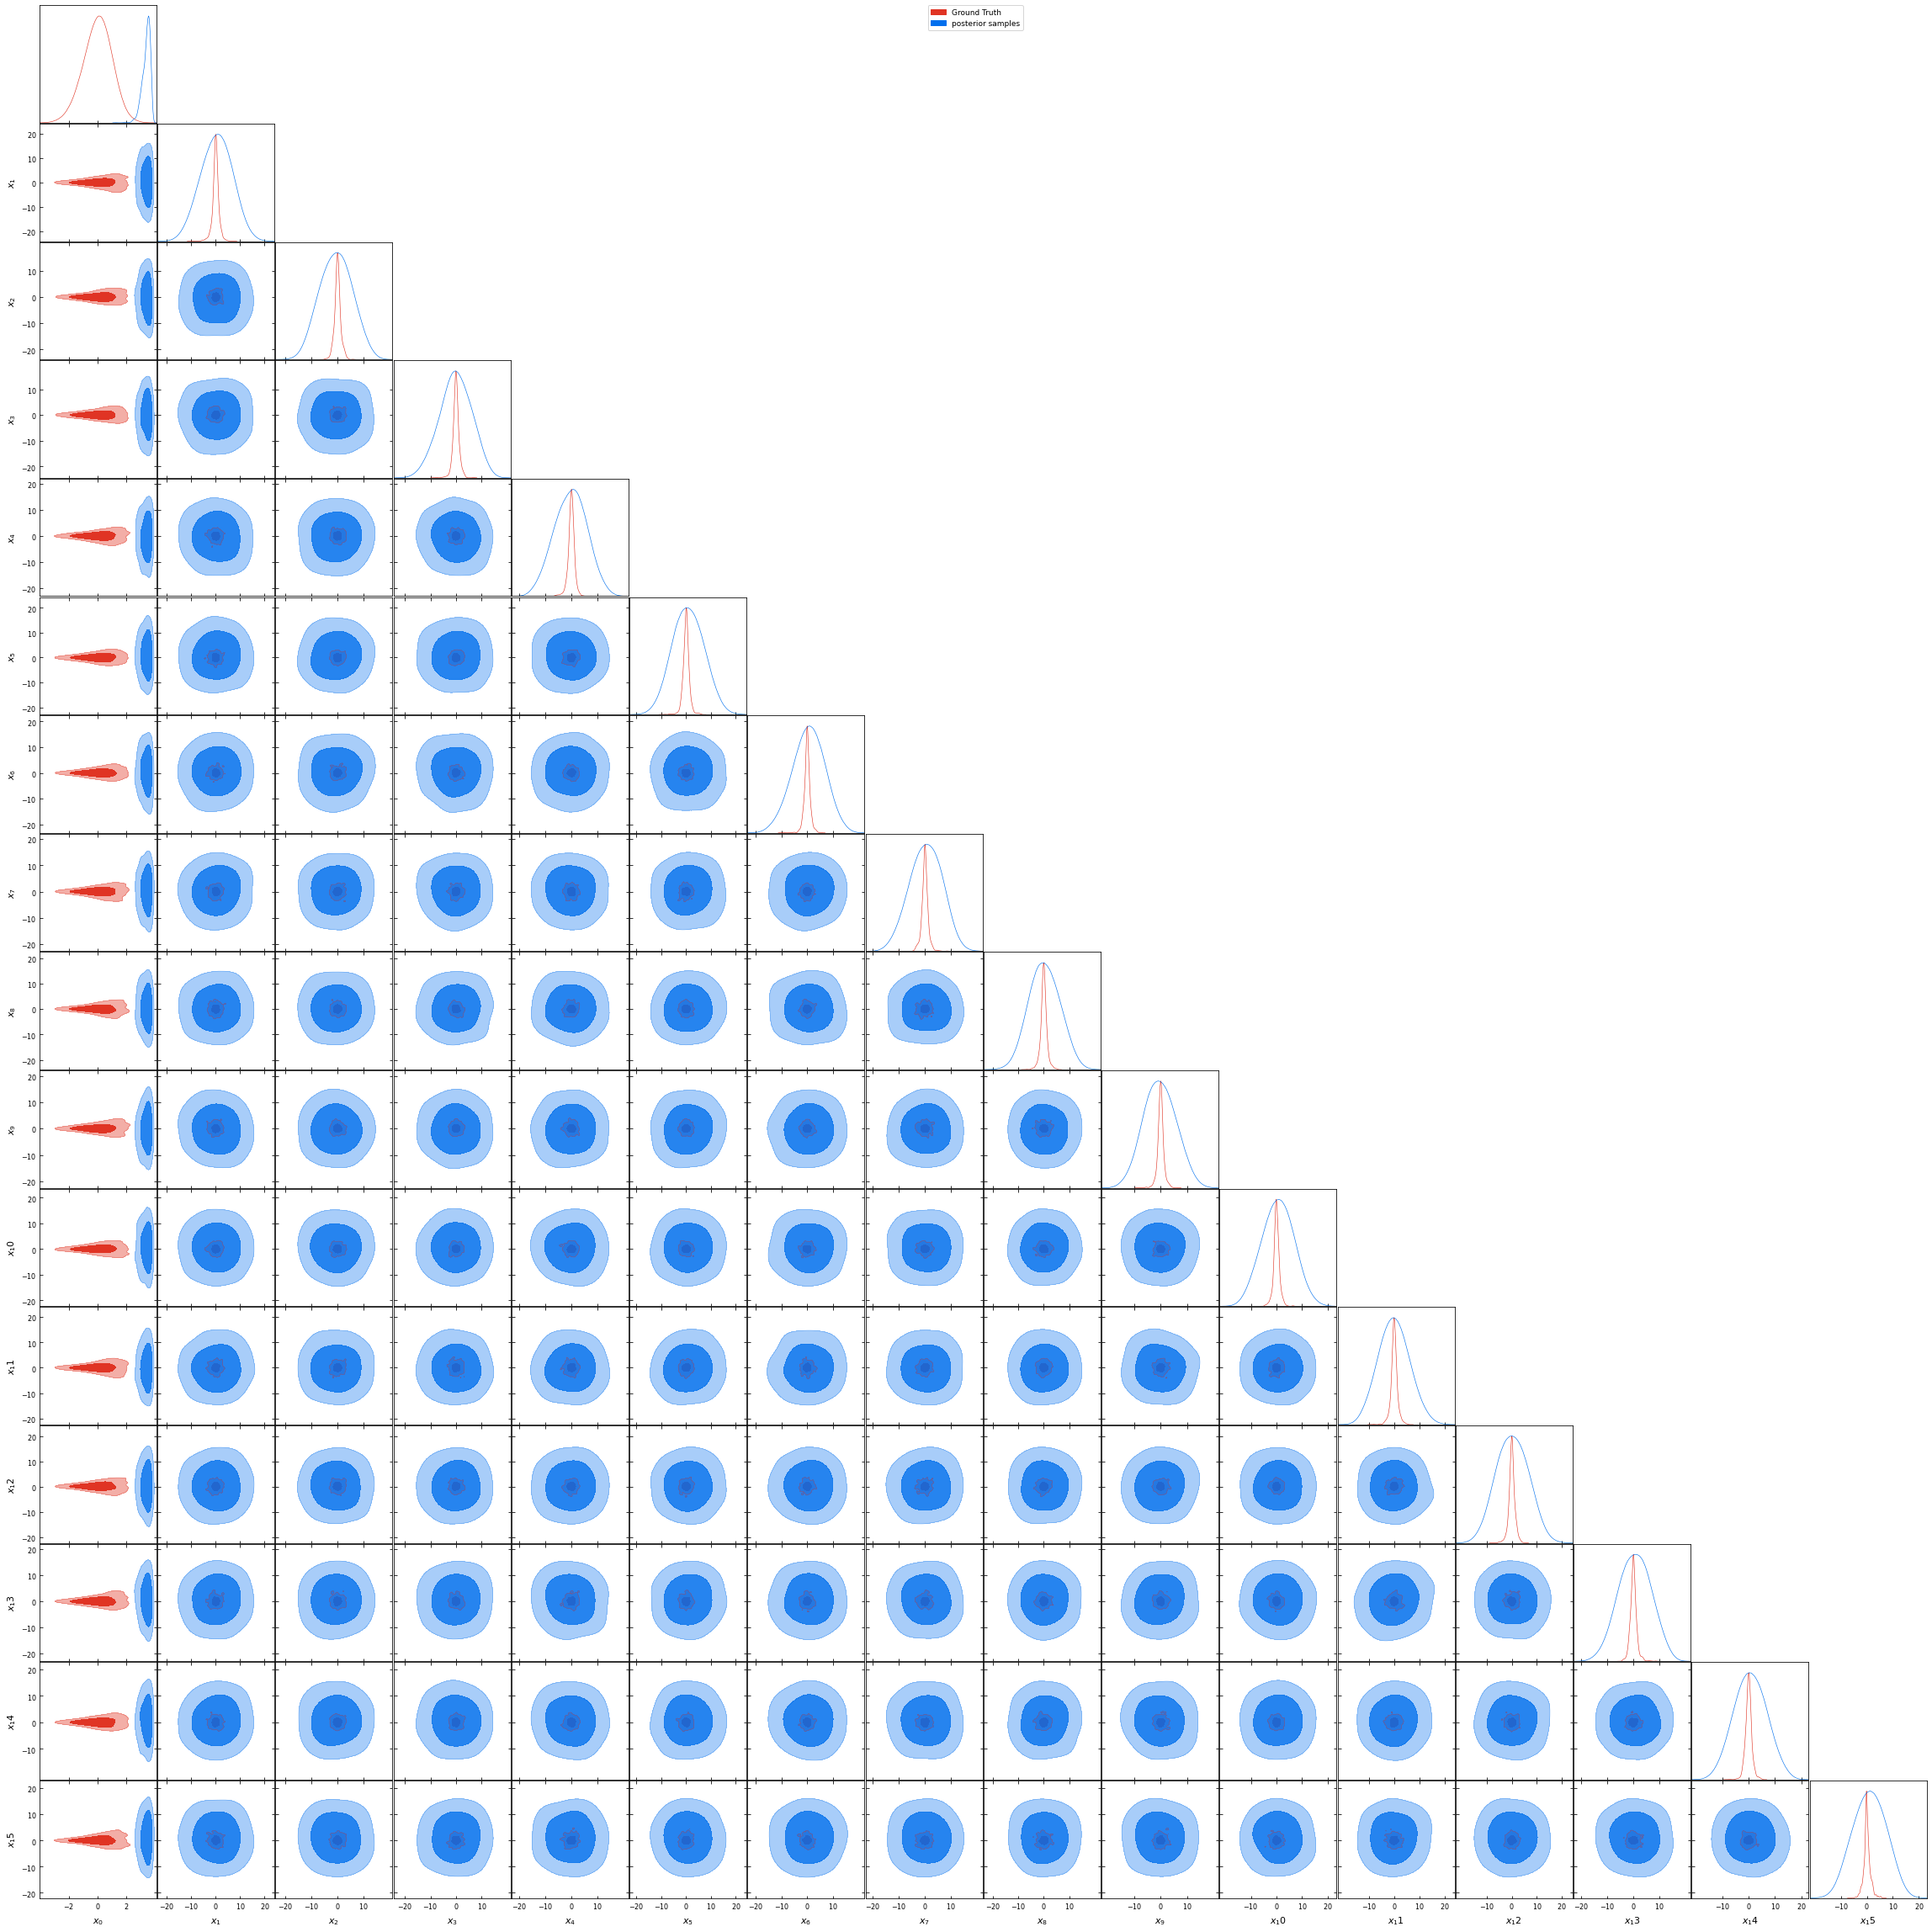

In [42]:
plot_triangles(q_samples, np.ones(len(q_samples)), truth_samples=x_prime)

# Whiten = True, Whiten_with_weights = True, NERCOME = False
Hangs at first beta level ...

In [43]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args, 
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=True,
                             Whiten_with_weights=True,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=False,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter)

Inference mode is sampling. Maximum beta is set to 1.
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.0005950927734375


KeyboardInterrupt: 

# Whiten = False, Whiten_with_weights = False, NERCOME = False

This will run, arguably with the best overlap with the funnel. Again, can be improved by repeatedly fitting at beta=1.

In [44]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args, 
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=False,
                             Whiten_with_weights=False,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=False,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter)

Inference mode is sampling. Maximum beta is set to 1.
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.0005950927734375
Time taken for trainable qw = 0.2730719810000437
Running latent space MH sampling for 25 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.00901543814688921
Time taken for trainable qw = 0.2356089490000386
Running latent space MH sampling for 3 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.053734817954136815
Time taken for trainable qw = 0.2447413330000927
Running latent space MH sampling for 13 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.13356210081148667
Time taken for trainable qw = 0.23382244100002936
Running latent space MH sampling for 5 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.24292369646706363
Time taken for trainable qw = 0.23536636200003613
Running latent space M

q9_w
Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

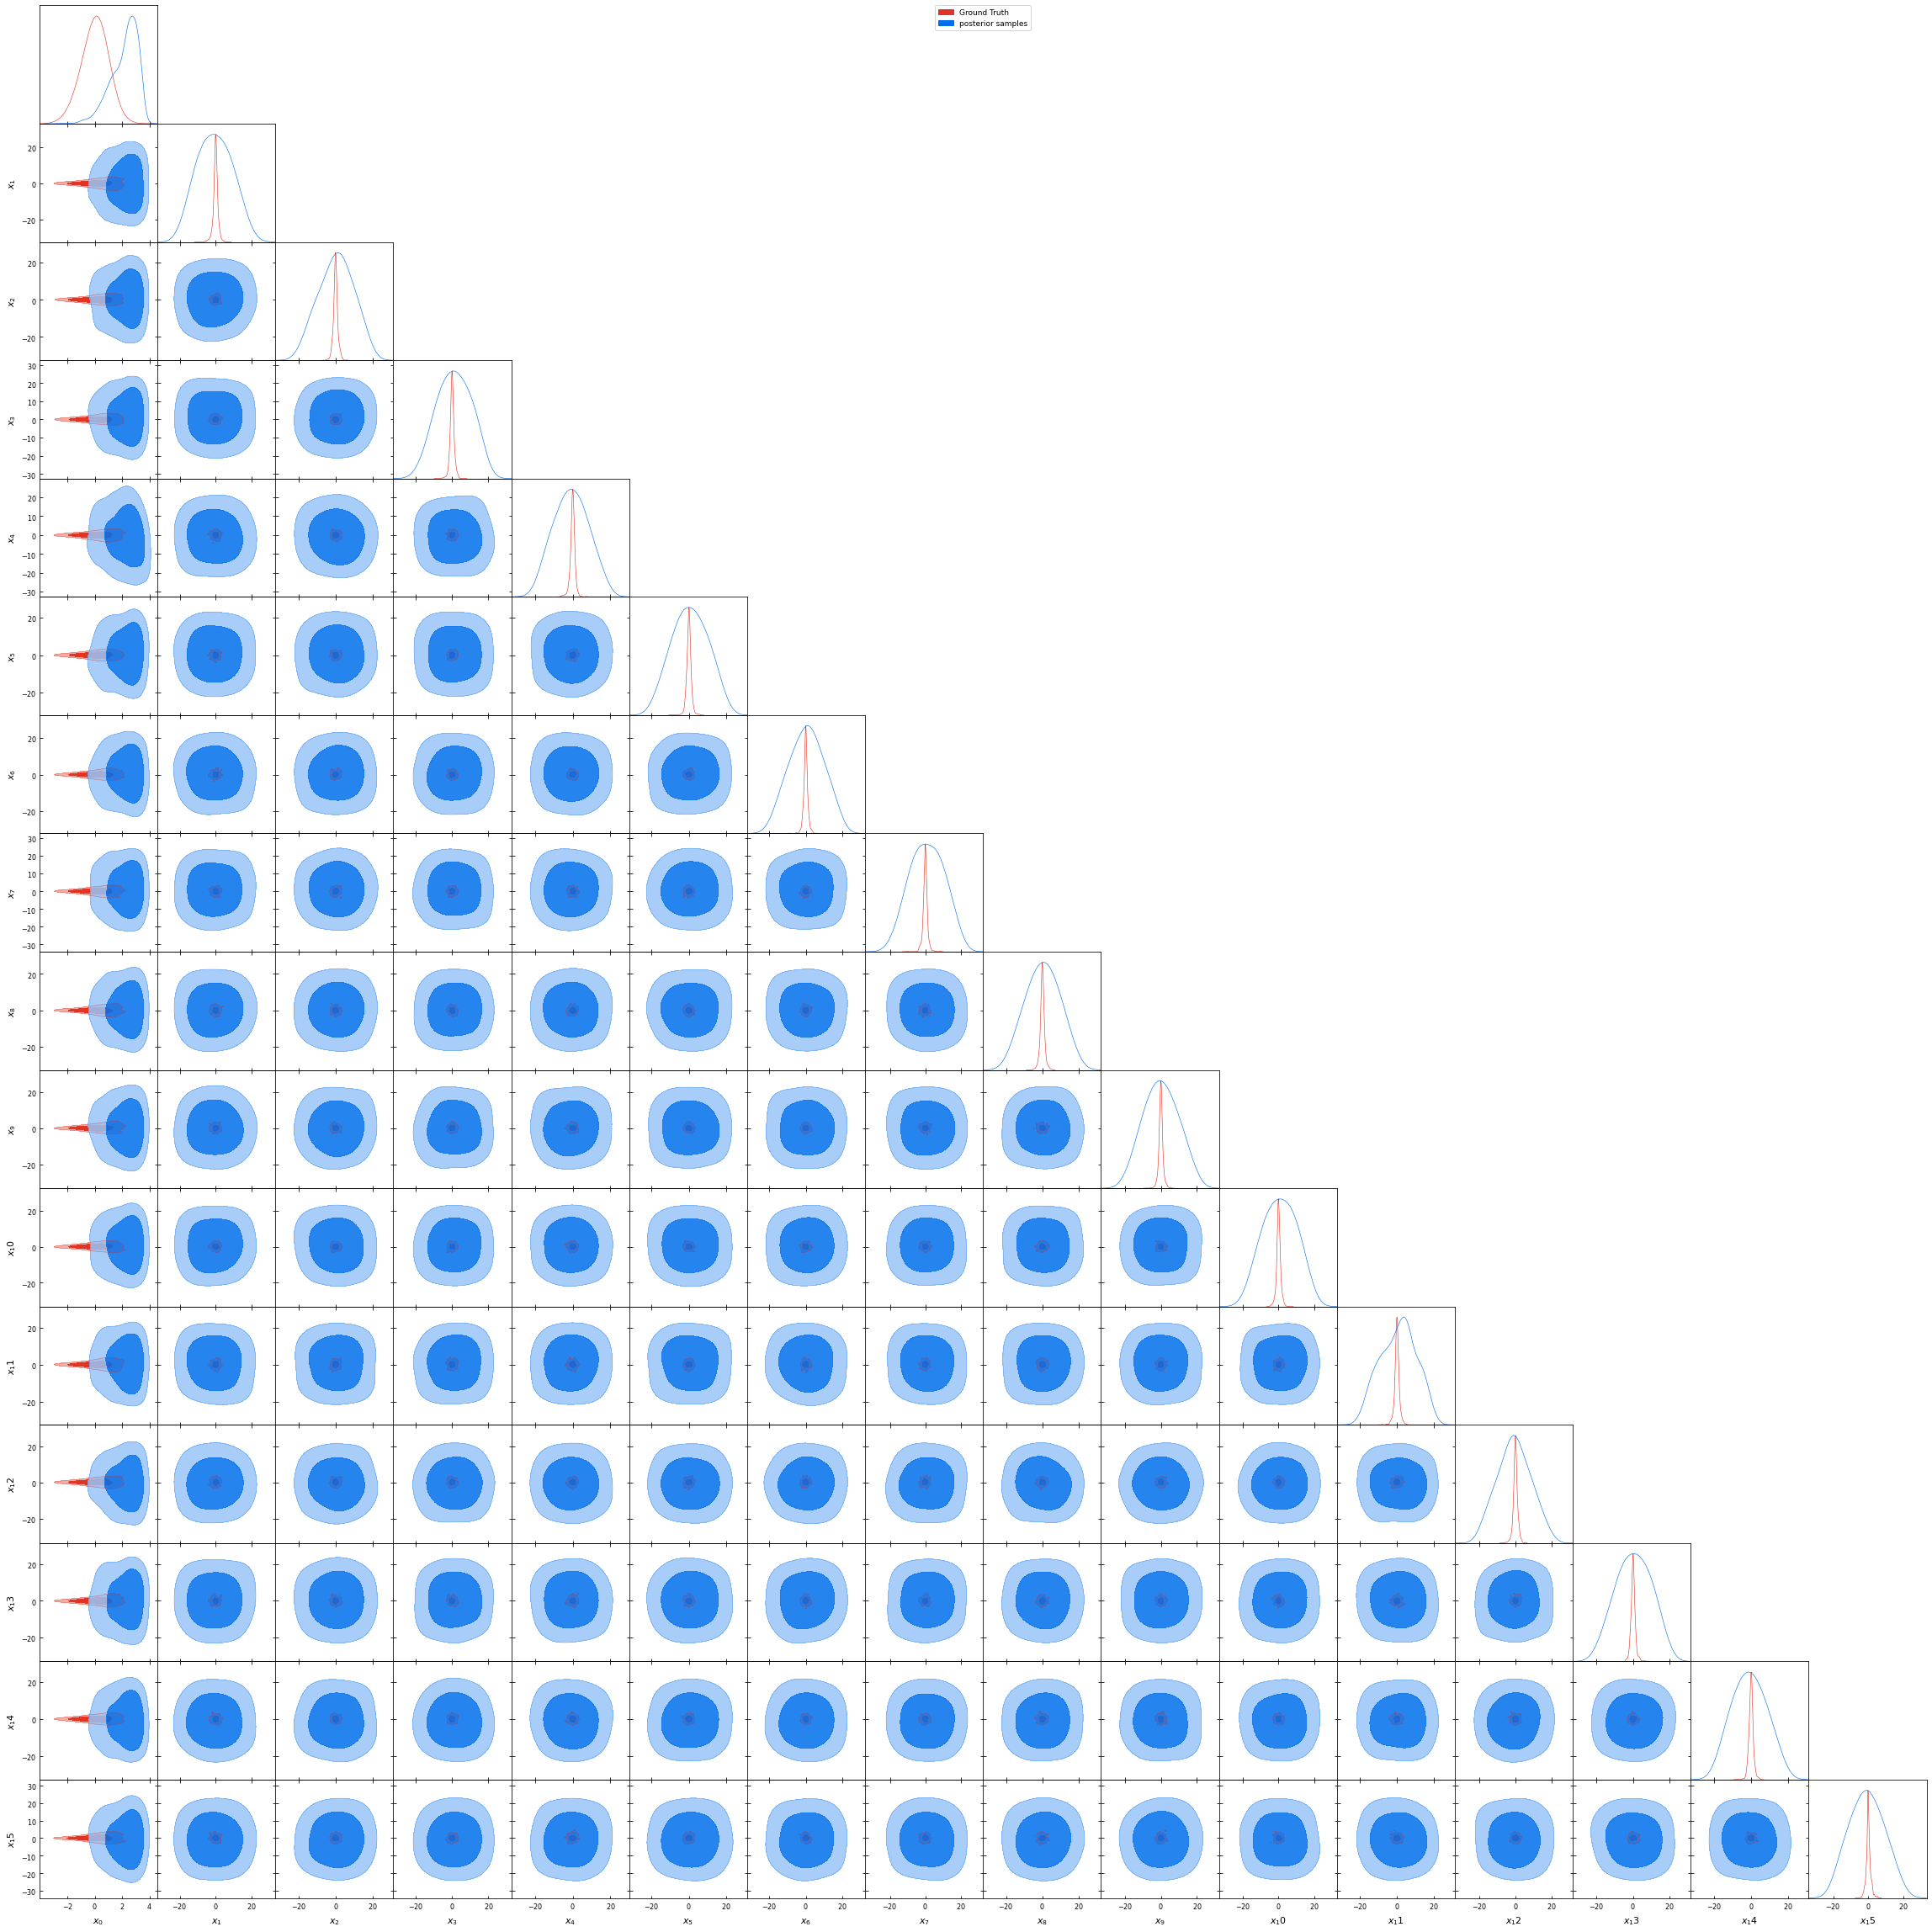

In [45]:
q_models = trace['q_models'][0]
print(list(q_models.keys())[-1])

qi = q_models[list(q_models.keys())[-1]]
q_samples, logq = qi.sample(2000, device='cpu')
q_samples, logq = q_samples.numpy(), logq.numpy()
iw = jax.vmap(lambda x: log_like(x))(q_samples)
logp = jax.vmap(lambda x: log_like(x))(q_samples)
logw = logp - logq
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

plot_triangles(q_samples, np.ones(len(q_samples)), truth_samples=x_prime)

# Whiten = False, Whiten_with_weights = False, NERCOME = True

Similar result to with NERCOME=False above ...

In [46]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args, 
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=False,
                             Whiten_with_weights=False,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=True,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter)

Inference mode is sampling. Maximum beta is set to 1.
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.0005950927734375
Time taken for trainable qw = 0.2853887080000277
Running latent space MH sampling for 25 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.00901543814688921
Time taken for trainable qw = 0.24370115299996087
Running latent space MH sampling for 3 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.053734817954136815
Time taken for trainable qw = 0.24717269899997518
Running latent space MH sampling for 13 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.13356210081148667
Time taken for trainable qw = 0.29527211200002057
Running latent space MH sampling for 5 steps
min_delta_beta = 0.01
ESS for samples from most recent qw = 160
Updated beta = 0.24292369646706363
Time taken for trainable qw = 0.28117044299995086
Running latent space

q9_w
Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

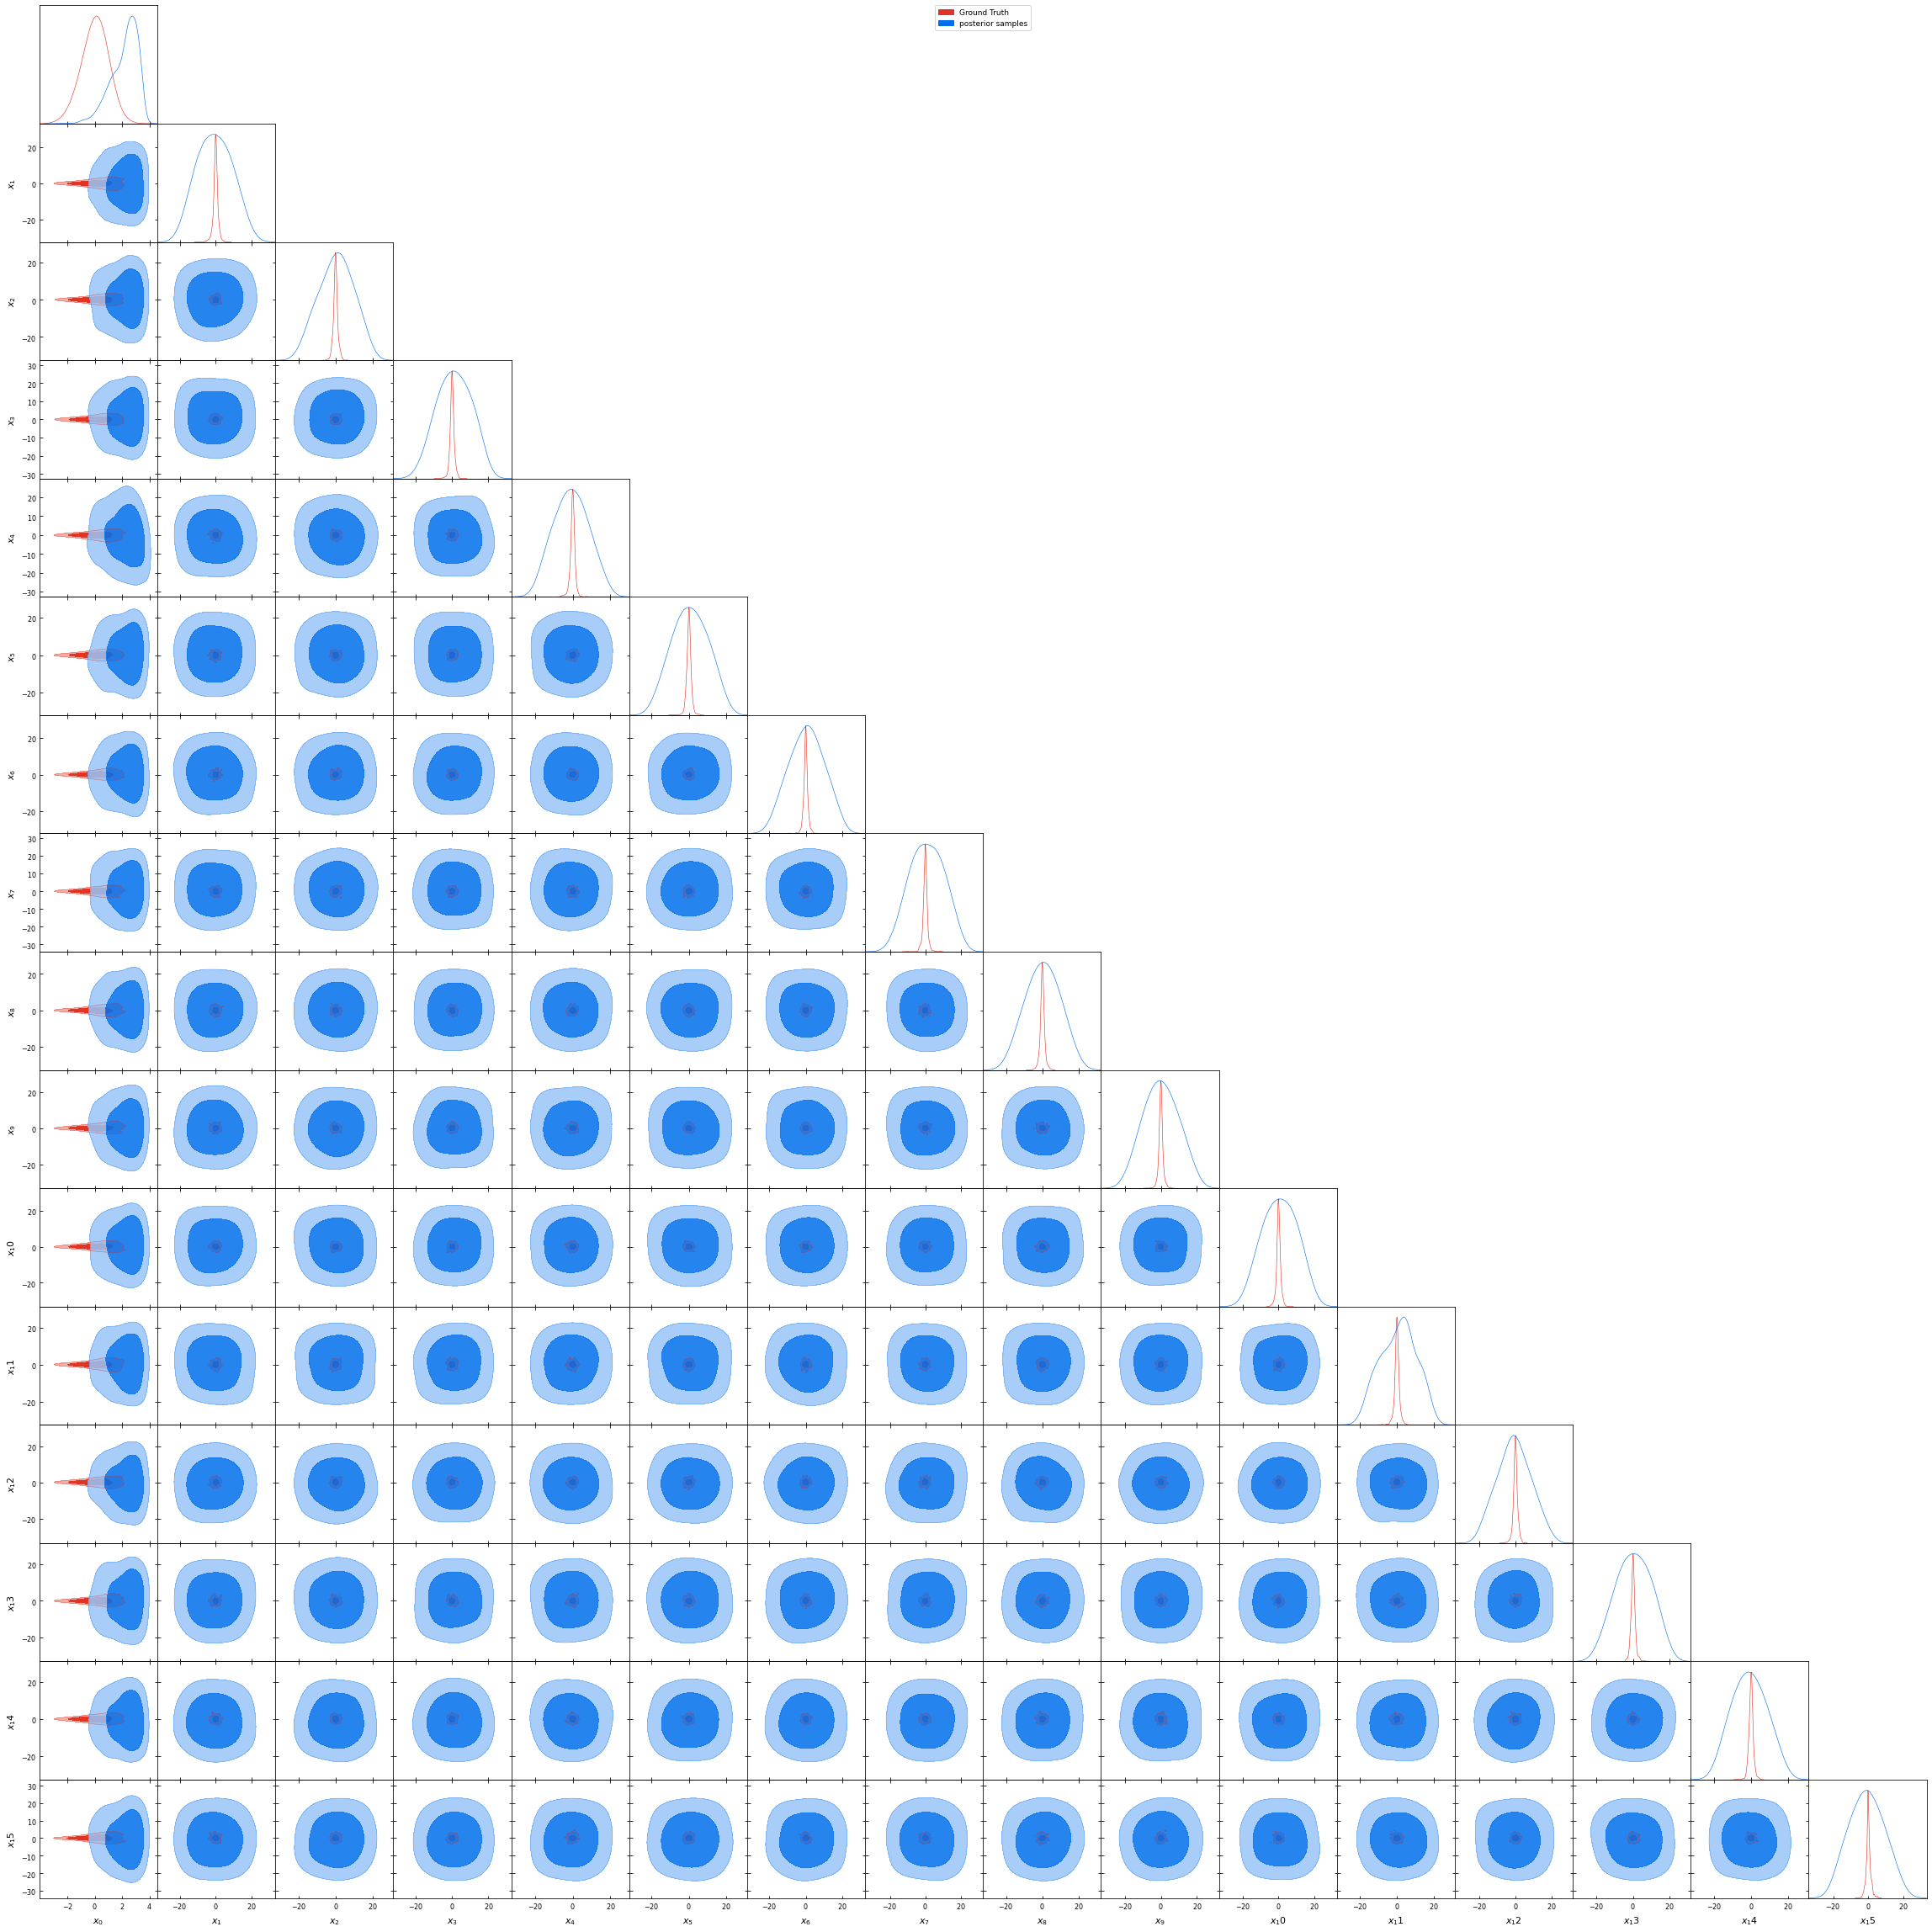

In [47]:
q_models = trace['q_models'][0]
print(list(q_models.keys())[-1])

qi = q_models[list(q_models.keys())[-1]]
q_samples, logq = qi.sample(2000, device='cpu')
q_samples, logq = q_samples.numpy(), logq.numpy()
iw = jax.vmap(lambda x: log_like(x))(q_samples)
logp = jax.vmap(lambda x: log_like(x))(q_samples)
logw = logp - logq
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

plot_triangles(q_samples, np.ones(len(q_samples)), truth_samples=x_prime)